In [27]:
import warnings
warnings.filterwarnings("ignore")

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Imbalanced dataset handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# SHAP explainability
import shap

In [28]:
# -----------------------
# 1. Load dataset
# -----------------------
df = pd.read_csv("GermanCredit.csv")   # make sure the file is in your notebook folder
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1000, 21)


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,... < 100 DM,6,critical account/other credits existing,domestic appliances,1169,unknown/no savings account,... >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee/official,1,yes,yes,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee/official,1,no,yes,0
2,no checking account,12,critical account/other credits existing,retraining,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,no,yes,1
3,... < 100 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee/official,2,no,yes,1
4,... < 100 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown/no property,53,none,for free,2,skilled employee/official,2,no,yes,0


In [29]:

# -----------------------
# 2. Basic EDA
# -----------------------
print("\n--- Info ---")
print(df.info())

print("\n--- Missing values ---")
print(df.isnull().sum())

print("\n--- Target distribution ---")
print(df['credit_risk'].value_counts())


--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status                   1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   amount                   1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   employment_duration      1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  10

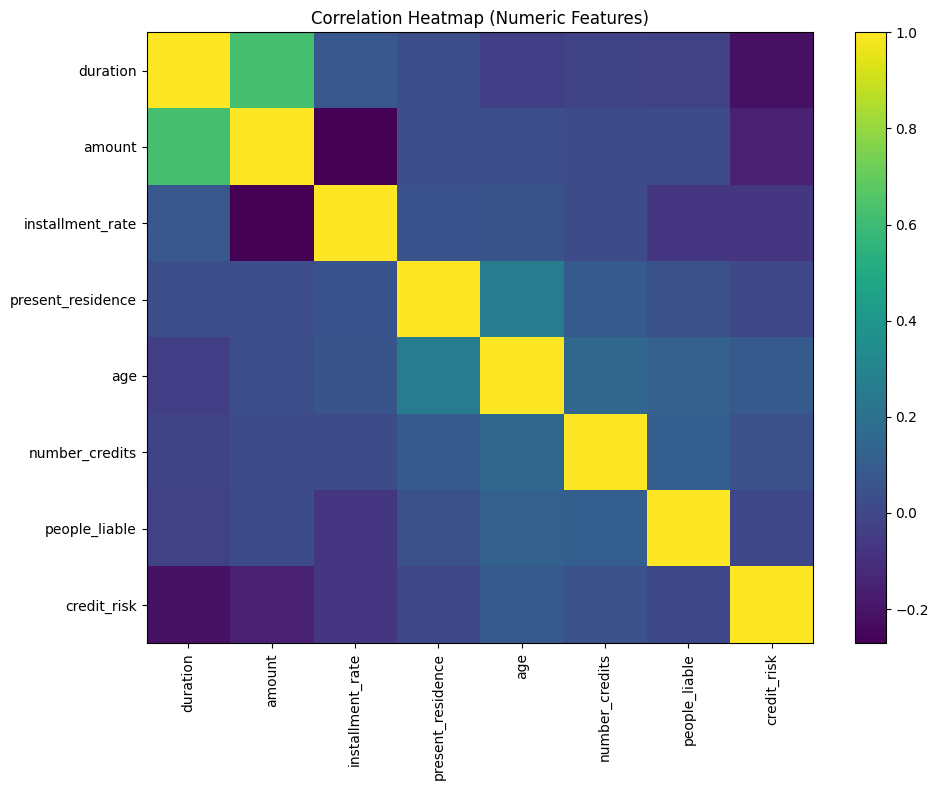

In [30]:

# -----------------------
# 3. Correlation Heatmap
# -----------------------
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

In [31]:

# -----------------------
# 4. Prepare features & target
# -----------------------
X = df.drop(columns=['credit_risk'])
y = df['credit_risk']

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

# Preprocessors
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # FIXED
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

Categorical: ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']
Numeric: ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']


In [32]:
# -----------------------
# 5. Train-test split
# -----------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)



Train: (800, 20) Test: (200, 20)


In [33]:
# -----------------------
# 6. Build model pipelines (with SMOTE)
# -----------------------
def make_pipeline(clf):
    return ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', clf)
    ])

pipe_lr = make_pipeline(LogisticRegression(solver='liblinear', random_state=42))
pipe_rf = make_pipeline(RandomForestClassifier(n_estimators=200, random_state=42))
pipe_xgb = make_pipeline(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))

In [34]:

# -----------------------
# 7. Train models
# -----------------------
pipe_lr.fit(X_train_raw, y_train)
pipe_rf.fit(X_train_raw, y_train)
pipe_xgb.fit(X_train_raw, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
# -----------------------
# 8. Evaluation function
# -----------------------
def evaluate_model(pipe, X_test, y_test, name):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC curve
    auc = roc_auc_score(y_test, y_proba)
    print("ROC-AUC:", auc)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC Curve - {name}")
    plt.show()

    return auc, classification_report(y_test, y_pred, output_dict=True)



=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.5000    0.7000    0.5833        60
           1     0.8448    0.7000    0.7656       140

    accuracy                         0.7000       200
   macro avg     0.6724    0.7000    0.6745       200
weighted avg     0.7414    0.7000    0.7109       200



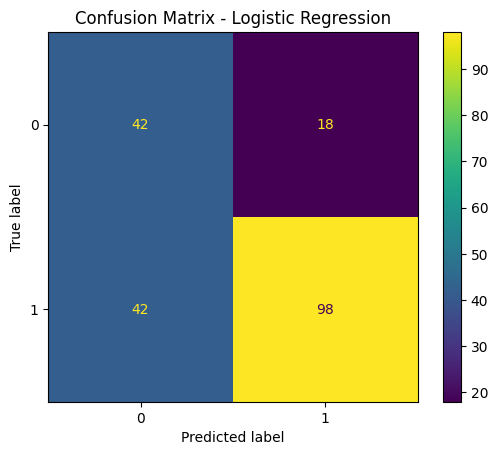

ROC-AUC: 0.7541666666666667


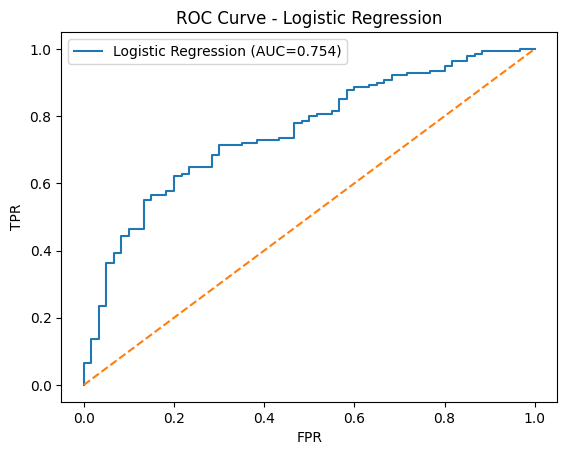


=== Random Forest ===
              precision    recall  f1-score   support

           0     0.5510    0.4500    0.4954        60
           1     0.7815    0.8429    0.8110       140

    accuracy                         0.7250       200
   macro avg     0.6662    0.6464    0.6532       200
weighted avg     0.7123    0.7250    0.7163       200



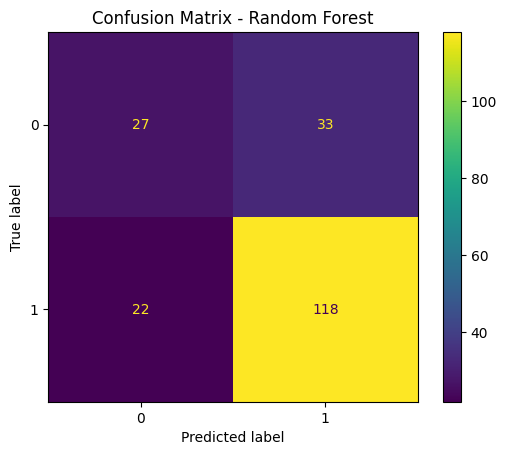

ROC-AUC: 0.7898809523809524


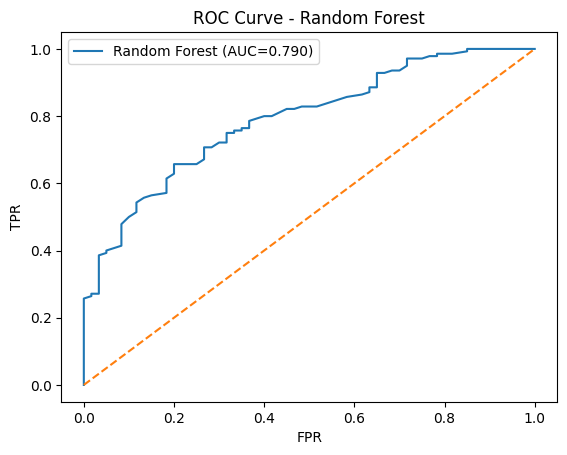


=== XGBoost ===
              precision    recall  f1-score   support

           0     0.5577    0.4833    0.5179        60
           1     0.7905    0.8357    0.8125       140

    accuracy                         0.7300       200
   macro avg     0.6741    0.6595    0.6652       200
weighted avg     0.7207    0.7300    0.7241       200



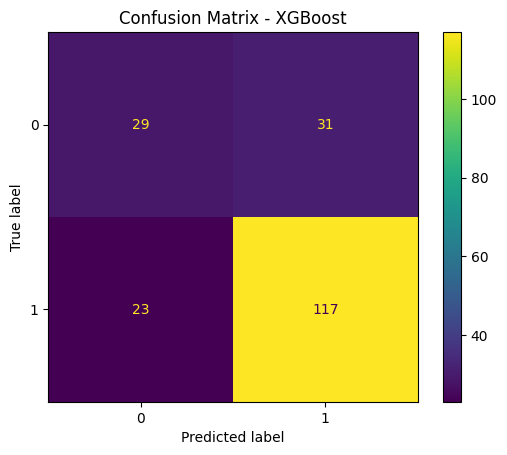

ROC-AUC: 0.7447619047619048


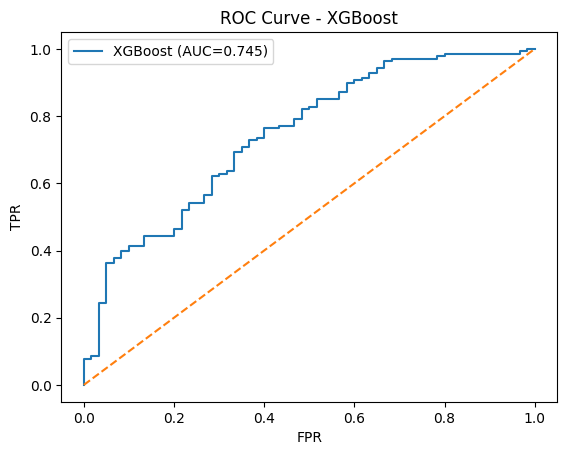

In [36]:
# -----------------------
# 9. Evaluate all models
# -----------------------
auc_lr, cr_lr = evaluate_model(pipe_lr, X_test_raw, y_test, "Logistic Regression")
auc_rf, cr_rf = evaluate_model(pipe_rf, X_test_raw, y_test, "Random Forest")
auc_xgb, cr_xgb = evaluate_model(pipe_xgb, X_test_raw, y_test, "XGBoost")

In [37]:
# -----------------------
# 10. Cross-validation
# -----------------------
print("\nCross-validation ROC-AUC (5-fold):")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, pipe in [("LR", pipe_lr), ("RF", pipe_rf), ("XGB", pipe_xgb)]:
    scores = cross_val_score(pipe, X, y, cv=skf, scoring='roc_auc')
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")


Cross-validation ROC-AUC (5-fold):
LR: 0.7789 ± 0.0159
RF: 0.7845 ± 0.0152
XGB: 0.7757 ± 0.0141


In [38]:
# -----------------------
# 11. Compare models
# -----------------------
summary = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "ROC-AUC": [auc_lr, auc_rf, auc_xgb],
    "F1": [cr_lr['1']['f1-score'], cr_rf['1']['f1-score'], cr_xgb['1']['f1-score']]
})
print("\nModel Comparison:")
print(summary)

best_model = summary.sort_values(by=["ROC-AUC","F1"], ascending=False).iloc[0]
print("\nBest Model:", best_model["Model"])


Model Comparison:
                 Model   ROC-AUC        F1
0  Logistic Regression  0.754167  0.765625
1        Random Forest  0.789881  0.810997
2              XGBoost  0.744762  0.812500

Best Model: Random Forest



Computing SHAP values...


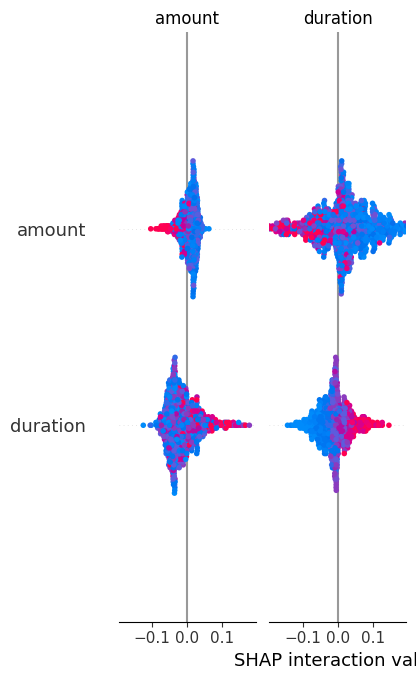

In [39]:
# -----------------------
# 12. SHAP Explainability (for best model)
# -----------------------
if best_model["Model"] == "Random Forest":
    best_pipe = pipe_rf
elif best_model["Model"] == "XGBoost":
    best_pipe = pipe_xgb
else:
    best_pipe = pipe_lr

preproc = best_pipe.named_steps['preprocessor']
clf = best_pipe.named_steps['clf']

X_train_transformed = preproc.transform(X_train_raw)

# Get feature names after one-hot encoding
num_names = numeric_cols
ohe = preproc.named_transformers_['cat'].named_steps['onehot']
cat_names = list(ohe.get_feature_names_out(categorical_cols))
feature_names = num_names + cat_names

print("\nComputing SHAP values...")
if best_model["Model"] in ["Random Forest","XGBoost"]:
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_train_transformed)
    if isinstance(shap_values, list): shap_values = shap_values[1]
else:
    explainer = shap.LinearExplainer(clf, X_train_transformed)
    shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

In [40]:
# -----------------------
# 13. Save best model
# -----------------------
import joblib
joblib.dump(best_pipe, f"best_model_{best_model['Model'].replace(' ','_')}.pkl")
print("Best model saved!")


Best model saved!
